### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 21 is here the size of the considered amino acid alphabet.


---

Jupyterhub keeps losing these packages, so just for setup:

In [1]:
! pip install pyvolve

In [2]:
! pip install plotly

In [3]:
import plotly.io as pio
pio.renderers.default = "iframe"

In [4]:
! pip install logomaker

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

---

In [5]:
# set this to None if "true" randomness is desired, otherwise the runs are reproducible given the same SEED and that the same simulated data is used
SEED = 42

In [6]:
#from Bio import SeqIO
#from Bio.Seq import Seq
#from Bio.SeqRecord import SeqRecord
#import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
#import scipy.stats
import tensorflow as tf
#import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

if SEED is not None:
    # enable deterministic tensorflow behaviour (https://github.com/NVIDIA/framework-determinism/blob/master/doc/tensorflow.md)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

import sys
sys.path.insert(0, 'modules/')
import importlib
import sequtils as su
print(importlib.reload(su))
import dataset as dsg
print(importlib.reload(dsg))
import model
print(importlib.reload(model))
#import aadist
#print(importlib.reload(aadist))
#import initProfilesExperiment as ipe
#print(importlib.reload(ipe))
import plotting
print(importlib.reload(plotting))
import stuff
print(importlib.reload(stuff))

#sys.path.insert(0, 'modules/GeneLinkDraw/')
#sys.path.insert(0, 'modules/MSAgen/')
#sys.path.insert(0, 'dataset/')
#import geneLinkDraw as gld
#print(importlib.reload(gld))
import Links
print(importlib.reload(Links))
#import MSAgen
#print(importlib.reload(MSAgen))
import SequenceRepresentation
print(importlib.reload(SequenceRepresentation))
import ProfileFindingSetup
print(importlib.reload(ProfileFindingSetup))

print(tf.__version__)

#%load_ext memory_profiler

<module 'sequtils' from 'modules/sequtils.py'>
<module 'dataset' from 'modules/dataset.py'>
<module 'model' from 'modules/model.py'>
<module 'plotting' from 'modules/plotting.py'>
<module 'stuff' from 'modules/stuff.py'>
<module 'Links' from 'modules/Links.py'>
<module 'SequenceRepresentation' from 'modules/SequenceRepresentation.py'>
<module 'ProfileFindingSetup' from 'modules/ProfileFindingSetup.py'>
2.5.0


In [7]:
tf.__version__.split('.')[0:2] < ['2','4']

False

In [8]:
use_toy_data = False
use_sim_data = False
use_real_data = True
assert use_toy_data or use_sim_data or use_real_data
assert not (use_toy_data and use_sim_data)
assert not (use_toy_data and use_real_data)
assert not (use_sim_data and use_real_data)

### Get Data

In [9]:
if use_toy_data:
    data = ProfileFindingSetup.ProfileFindingDataSetup('toy')
    data.addGenomes(verbose = False)
    _, _ = data.expectedPatterns()
if use_sim_data:
    data = ProfileFindingSetup.ProfileFindingDataSetup('sim')
    data.addGenomes(verbose = True)
if use_real_data:
    sequences = SequenceRepresentation.loadJSONSequenceList("/home/jovyan/brain/genomegraph/data/241_species/run_subset150/out_10Exons_subset150_withEnforced_20_15_20_50_15_20_15_20_mammals/exon_chr13_100273195_100273346/profile_finding_sequence_data.json")
    genomes = []
    for seq in sequences:
        genomes.append(SequenceRepresentation.Genome())
        genomes[-1].addSequence(seq)
    
    data = ProfileFindingSetup.ProfileFindingDataSetup('real')
    data.addGenomes(genomes, verbose=True)

background freqs:  4001282.0 *
C 0.0354
K 0.0615
E 0.0344
W 0.0146
T 0.0536
G 0.0404
Y 0.0372
A 0.0357
I 0.0649
N 0.0446
V 0.0537
H 0.0330
S 0.0892
D 0.0234
F 0.0605
M 0.0196
R 0.0450
L 0.1139
P 0.0404
Q 0.0378
* 0.0613


#### TODO: look closer into this, how many sequences have annotation at all and how many just lack annotation of the gene

In [10]:
nannot = 0
nsequences = 0
for genome in data.genomes:
    for sequence in genome:
        nsequences += 1
        if hasattr(sequence, 'genomic_elements') and len(sequence.genomic_elements):
            nannot += 1
        
print(nannot, '/', nsequences)

48 / 85


In [11]:
print(len(data.genomes), len(data.genomes[0]), len(data.genomes[0][0]))

85 1 61757


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

### Setup Training

    U = 200, tiles_per_X = 13: 6630,315,1,4449
    U = 100, tiles_per_X = 13: 6630,315,1,4449
    U = 200, tiles_per_X =  7: 3570,4449,315,1

In [25]:
trainsetup = ProfileFindingSetup.ProfileFindingTrainingSetup(data,
                                                             tiles_per_X = 7,
                                                             U = 200, n_best_profiles=5)
trainsetup.print()

data.mode = real
data.N = 85
data.Q = [0.03542539 0.06154777 0.03439098 0.01459832 0.05356733 0.04038706
 0.03720083 0.03571755 0.06493869 0.04460645 0.05366955 0.03296344
 0.08918142 0.02340325 0.06045112 0.01956573 0.04495109 0.11392999
 0.04043454 0.03781438 0.06125512]
data.toy_genomeSizes = None
data.toy_insertPatterns = None
data.toy_repeatPatterns = None
data.toy_repeatsPerGenome = None
data.toy_multiplyRepeats = None
data.toy_mutationProb = None
data.sim_seqlen = None
data.sim_genelen = None
data.sim_cdist = None
data.sim_ncdist = None
data.sim_tree = None
data.sim_omega = None
tile_size = 334
batch_size = 1
tiles_per_X = 7
prefetch = 3
U = 200
k = 20
midK = 12
s = 0
epochs = 350
alpha = 1e-06
gamma = 1
l2 = 0.01
match_score_factor = 0.7
learning_rate = 2
lr_patience = 5
lr_factor = 0.75
rho = 0
sigma = 1
profile_plateau = 10
profile_plateau_dev = 150
n_best_profiles = 5
lossStrategy = experiment
steps_per_epoch = 7.0
initProfiles = None
trackProfiles = None
initKmerPositions =

[INFO] >>> Number of profiles: 200


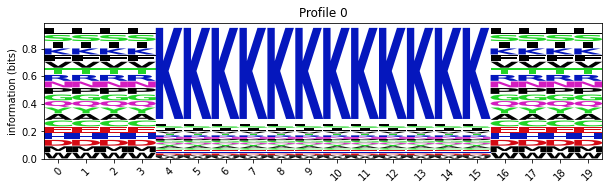

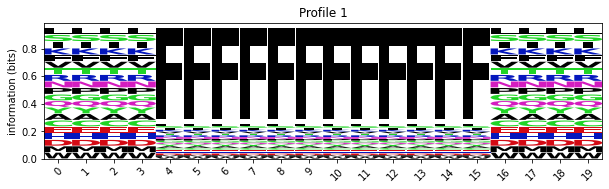

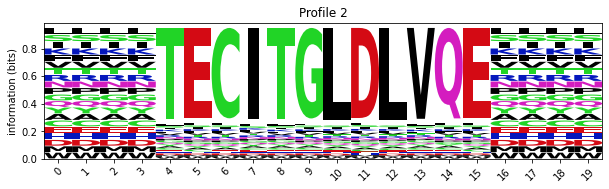

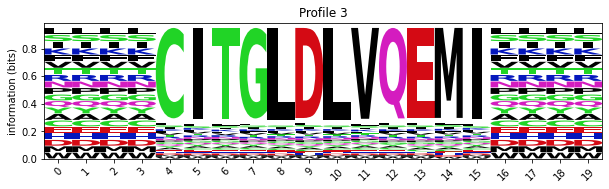

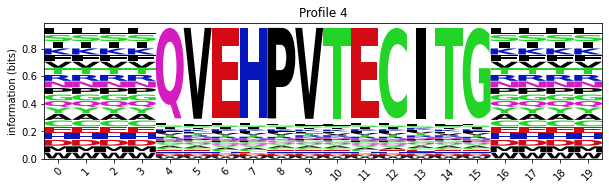

In [26]:
trainsetup.initializeProfiles(enforceU=False, plot=True, overlapTilesize=6)

In [27]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
specProModel = None
specProModel = model.SpecificProfile(setup = trainsetup,
                                     alphabet_size = su.aa_alphabet_size, 
                                     rand_seed = SEED)

if trainsetup.initProfiles is None:
    %time P_logit_init = specProModel.seed_P_genome(genomes)
    specProModel.setP_logit(P_logit_init)

[DEBUG] >>> setting tf global seed to 42
[DEBUG] >>> using softmaxLoss: False // using experimentLoss: True
[DEBUG] >>> Using initProfiles from training setup instead of random


### Training

Hint: If training fails (because conv2d throws strange errors), try shutdown all kernels,
in a terminal execute `rm -r ~/.nv` to clear some cache and restart kernel. Usually it then works again.

In [28]:
trainingWithReporting = True

In [29]:
genomes

[Genome from Homo_sapiens with 1 chromosomes: chr13,
 Genome from Mus_musculus with 1 chromosomes: chr14,
 Genome from Felis_catus with 1 chromosomes: CM001378.2,
 Genome from Canis_lupus_familiaris with 1 chromosomes: chr22,
 Genome from Bos_taurus with 1 chromosomes: CM000188.7,
 Genome from Rattus_norvegicus with 1 chromosomes: chr15,
 Genome from Gorilla_gorilla with 1 chromosomes: LT578328.1,
 Genome from Pongo_abelii with 1 chromosomes: CM009275.2,
 Genome from Ochotona_princeps with 1 chromosomes: JH802062.1,
 Genome from Erinaceus_europaeus with 1 chromosomes: JH835328.1,
 Genome from Elephantulus_edwardii with 1 chromosomes: JH947132.1,
 Genome from Condylura_cristata with 1 chromosomes: JH655887.1,
 Genome from Jaculus_jaculus with 1 chromosomes: JH725497.1,
 Genome from Ctenodactylus_gundi with 1 chromosomes: CteGun_scaffold_4030,
 Genome from Tupaia_chinensis with 1 chromosomes: KB320462.1,
 Genome from Marmota_marmota with 1 chromosomes: CZRN01000014.1,
 Genome from Otolem

In [30]:
start = time()
if trainingWithReporting:
    specProModel.train_reporting(verbose_freq=10)
else:
    specProModel.train_classic(trainsetup.getDataset(repeat=True))
    
end = time()
print(f"time: {end-start:.2f}")

ResourceExhaustedError: OOM when allocating tensor with shape[3570,4449,315,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

## Training History

In [ ]:
plotting.plotHistory(specProModel.history)

Loss history of trained profiles over epochs

In [ ]:
if trainingWithReporting:
    plh = tf.transpose(specProModel.P_report_plosshist).numpy()
    fig, ax = plt.subplots(1,1, figsize=(2*1920/100,2*1080/100), dpi=100)
    hm = ax.imshow(plh, interpolation = 'nearest', cmap="rainbow")
    plt.colorbar(hm)
    fig.show()

ID and loss of the best profile after each epoch

In [ ]:
if trainingWithReporting:
    bestlosshist = [l.numpy() for l in specProModel.P_report_bestlosshist]
    bestlosshistIdx = [i.numpy() for i in specProModel.P_report_bestlosshistIdx]

In [ ]:
if trainingWithReporting:
    import plotly.express as px
    px.scatter(x = list(range(len(bestlosshist))),
               y = bestlosshist, 
               color = bestlosshistIdx).show()

Change of best profile ID after each epoch (color change == ID change)

In [ ]:
if trainingWithReporting:
    c = 0
    bincol = [c]
    for i in range(1,len(bestlosshistIdx)):
        if bestlosshistIdx[i] != bestlosshistIdx[i-1]:
            c += 1

        bincol.append(c)

    bincol = [c%2 for c in bincol]

    px.scatter(x = list(range(len(bestlosshist))),
               y = bestlosshist, 
               color=bincol).show()

## Results

### Visualize resulting profiles as sequence logos

In [ ]:
if len(specProModel.P_report_discarded) > 0:
    Pedge = tf.nn.softmax(tf.transpose(specProModel.P_report_discarded, [1,2,0]), axis=1)
    print("Edge cases:")
    plotLogo(Pedge)

In [ ]:
if trainingWithReporting:
    _,_ = data.expectedPatterns()
    P, Pthresh, Ploss = specProModel.getP_report()
    Pwhole, PwholeScore, PwholeLoss = specProModel.getP_report_whole()
    plotting.plotLogo(P=P, pScores=np.array(Pthresh)/specProModel.setup.match_score_factor, pLosses=Ploss, max_print=10)#, label="Score Threshold")
    #plotLogo(P=Pwhole, pScores=PwholeScore, pLosses=PwholeLoss, max_print=10)#, label="Score Threshold")
    
else:
    P, scores, losses = specProModel.getP_optimal(0, lossStatistics=True)
    _,_ = data.expectedPatterns()
    pScores = specProModel.max_profile_scores(specProModel.setup.getDataset())
    pLosses = specProModel.min_profile_losses(specProModel.setup.getDataset())
    # sort after loss
    plotting.plotLogo(P=P, idxarray = np.argsort(pLosses), pScores=pScores, pLosses=pLosses, max_print=5)#, label="loss")
    # sort after scores
    #plotLogo(P=P, idxarray = np.argsort(pScores)[::-1], pScores=pScores, pLosses=pLosses, max_print=5)#, label="loss")

### Draw Link Image

In [ ]:
# get match sites of profiles
thresh = Pthresh if trainingWithReporting else specProModel.setup.match_score_factor * scores

onlyPid = None
if onlyPid is None:
    sites, siteScores, _ = specProModel.get_profile_match_sites(specProModel.setup.getDataset(withPosTracking = True, original_data=True), 
                                                                thresh, otherP = P)
else:
    sites, siteScores, _ = specProModel.get_profile_match_sites(specProModel.setup.getDataset(withPosTracking = True, original_data=True), 
                                                                thresh[onlyPid], otherP = P[:,:,onlyPid:onlyPid+1])
    
print("[DEBUG] >>> sites:", sites.numpy()[:20,]) # (sites, (genomeID, contigID, pos, u, f))
#print(siteScores)

In [ ]:
importlib.reload(Links)
#links, linkProfiles, skipped = plotting.sitesToLinks(sites.numpy(), 1000)
links, linkProfiles, skipped = Links.linksFromSites(sites, specProModel.setup.k*3, specProModel.setup.data.genomes, 1000)
print("[DEBUG] >>> links[:5]", links[:5])
print("[DEBUG] >>> len(links)", len(links))
#links = [sorted(l) for l in links]

In [ ]:
linkProfiles

In [ ]:
links[0].MSA()

In [ ]:
links[0].MSA(True)

In [ ]:
kmerSites = []
for kmer in trainsetup.initKmerPositions:
    kmerSites.extend(trainsetup.initKmerPositions[kmer])

masksides = specProModel.getMaskedSites(0)

plotting.drawGeneLinks_SequenceRepresentationData(data.genomes, links, 
                                                  imname=None, kmerSites=kmerSites, kmerCol='deeppink',
                                                  maskingSites=masksides, maskingCol='chocolate')

In [ ]:
trainsetup.data.Q

In [ ]:
specProModel.setup.data.extractSequences()[3][0]

---

In [ ]:
assert False

## Investigate

In [ ]:
if len(specProModel.P_report):
    plt.hist(tf.reshape(specProModel.getP_report_raw(), (-1)).numpy())
else:
    plt.hist(tf.reshape(specProModel.P_logit, (-1)).numpy())

In [ ]:
specProModel.P_report_plosshist.shape

In [ ]:
plt.hist(tf.reshape(specProModel.P_report_plosshist, (-1)).numpy())

In [ ]:
blhwindow = bestlosshist[52:62]
plt.hist(blhwindow)
print(np.mean(blhwindow))
print(np.std(blhwindow))
print([v-np.mean(blhwindow) for v in blhwindow])

In [ ]:
#tf.reduce_sum(tf.math.square(specProModel.P_logit), axis=[0,1]) / specProModel.P_logit.shape[0] * l2

In [ ]:
#tf.reduce_sum(specProModel.P_logit, axis=[0,1]) #* 0.001

In [ ]:
#specProModel.P_logit[:,:,0]
#specProModel.getP_report_raw()[:,:,1]

In [ ]:
Rcount = 0
sumlen = 0
for s in su.six_frame_translation(data.extractSequences()[0][0]):
    Rcount += s.count('R')
    sumlen += len(s)
    
print(Rcount, sumlen, Rcount/sumlen, 6/64)

In [ ]:
if trainingWithReporting:
    for i in range(len(specProModel.P_report)):
        print("profile", i, "-- nsites:", len(specProModel.P_report_masked_sites[i]), "// nlinks:", specProModel.P_report_nlinks[i].numpy())

In [ ]:
if trainingWithReporting and False:
    for s in specProModel.P_report_masked_sites[0]:
        print(s[0])
        g = s[1].numpy()
        c = s[2].numpy()
        a = s[3].numpy()
        b = s[4].numpy()
        print(genomes[g][c][a-5:b+5])

In [ ]:
import plotly.express as px

if not trainingWithReporting:
    fig = px.histogram(x=pLosses)
    fig.show()

    print(scipy.stats.describe(pLosses))
    print("mean:", np.mean(pLosses))
    print("std: ", np.std(pLosses))
    print("-Z: ", np.mean(pLosses)-np.std(pLosses))
    print("-2Z:", np.mean(pLosses)-2*np.std(pLosses))

In [ ]:
if trainingWithReporting:
    for i in range(len(specProModel.P_report)):
        print("profile", i, "-- kmer scores:", specProModel.P_report_kmer_scores[i])
        
else:
    printExpectedPatterns()
    z = np.mean(pLosses)-np.std(pLosses) # more or less reasonable loss cutoff
    P, scores, losses = specProModel.getP_optimal(dsh, z)
    plotLogo(P=P, idxarray = np.argsort(losses), pScores=scores, pLosses=losses, max_print=5)#, label="loss")

In [ ]:
#if not trainingWithReporting:
#    printExpectedPatterns()
#    plotLogo(P=P, idxarray = np.argsort(-scores), pScores=scores, pLosses=losses, max_print=5)#, label="loss")

In [ ]:
#assert False # stop if run all cells

### Get Sensitivity and Specificity

In [ ]:
midK = 6
kmerCount = {}
genomes = data.extractSequences()
for g in range(len(genomes)):
    for c in range(len(genomes[g])):
        for seq in su.six_frame_translation(genomes[g][c]):
            for i in range(len(seq)-midK+1):
                kmer = seq[i:i+midK]
                if (' ' not in kmer):
                    if kmer not in kmerCount:
                        kmerCount[kmer] = 0

                    kmerCount[kmer] += 1

In [ ]:
len(kmerCount)

In [ ]:
maxbin = max([kmerCount[i] for i in kmerCount])
maxbin

In [ ]:
n, bins, _ = plt.hist(x = [kmerCount[i] for i in kmerCount], #if kmerCount[i] >= len(genomes)], 
                      bins = list(range(1, maxbin+1)))

In [ ]:
len(n)

In [ ]:
print("Cumulative number of profiles when kmer occurs >= bin times")
[(str(bins[i])+"-"+str(bins[i+1]), sum(n[i:])) for i in range(len(n))]

In [ ]:
def makeP(count, kmerCount=kmerCount, specProModel=specProModel, geq=False):
    if geq:
        kmers = [kmer for kmer in kmerCount if kmerCount[kmer] >= count]
    else:
        kmers = [kmer for kmer in kmerCount if kmerCount[kmer] == count]
        
    P = np.array([dsg.oneHot(kmer) for kmer in kmers]) # U, k, 21
    P = np.transpose(P, (1,2,0))
    R = specProModel.getR(P).numpy() # (k, 21, U)
    thresh = np.sum(np.multiply(P, R), axis=(0,1), dtype=np.float32) # U, P acts as "sequence", thus calculating the match score of a perfect kmer match in the sequence
    if not geq:
        print("[INFO] >>> Expected number of sites:", count, "*", P.shape[2], "=", count*P.shape[2])
    else:
        print("[INFO] >>> Expected number of sites:", sum([kmerCount[kmer] for kmer in kmerCount if kmerCount[kmer] >= count]))
        
    return P, thresh

In [ ]:
if False:
    P, Pthresh = makeP(12, geq=True)
    print(P.shape)

In [ ]:
if trainingWithReporting:
    trainsetup.genomeToAllUC()
    #for g in range(len(dsh.genomes)):
    #    for c in range(len(dsh.genomes[g])):
    #        dsh.genomes[g][c] = dsh.genomes[g][c].upper()

# get match sites of profiles
thresh = Pthresh if trainingWithReporting else 0.9*scores #match_score_factor*scores

onlyPid = None
if onlyPid is None:
    sites, siteScores, _ = specProModel.get_profile_match_sites(trainsetup.getDataset(withPosTracking = True), thresh, otherP = P)
else:
    sites, siteScores, _ = specProModel.get_profile_match_sites(trainsetup.getDataset(withPosTracking = True), thresh[onlyPid], otherP = P[:,:,onlyPid:onlyPid+1])
    
print(sites.numpy()[:20,]) # (sites, (genomeID, contigID, pos, u, f))
#print(siteScores)

In [ ]:
if not use_sim_data:
    links, linkProfiles, skipped = plotting.sitesToLinks(sites.numpy(), 1000)
    print(links[:5])
    print(len(links))
    links = [sorted(l) for l in links]

In [ ]:
if not use_sim_data:
    if len(skipped):
        fig = px.histogram(x=[s[1] for s in skipped])
        fig.show()

### Draw Link Image

In [ ]:
print(specProModel.tracking['masking'])

In [ ]:
def getMaskedSites(idx, specProModel=specProModel):
    sites = []
    for site in specProModel.P_report_masked_sites[idx]:
        seq, g, c, a, b = site
        #print(seq, g.numpy(), c.numpy(), a.numpy(), b.numpy())
        sites.append((g.numpy(), c.numpy(), a.numpy()))
    
    return sites

In [ ]:
sites.numpy()

In [ ]:
links

In [ ]:
importlib.reload(plotting)
drawGeneLinks = True
if drawGeneLinks and False:
    if use_sim_data:
        #plotting.drawGeneLinks_simData(genomes, links, posDict, kmerSites=kmerPositions, kmerCol='greenyellow',
        #                               imname='/home/jovyan/brain/genomegraph/learn_specific_profiles/links.png')
        masksides = getMaskedSites(0)
        #masksides.extend(getMaskedSites(1))
        plotting.drawGeneLinks_simData(genomes, sites.numpy(), posDict, linksAreSites=True, kmerSites=kmerPositions, kmerCol='deeppink',
                                       maskingSites=masksides, maskingCol='chocolate',
                                       imname='/home/jovyan/brain/genomegraph/learn_specific_profiles/links.png', linkwidth=4)
        
    if use_real_data and False:
        #plotting.drawGeneLinks_realData(datapath, seqnames, links,
        #                                '/home/jovyan/brain/genomegraph/learn_specific_profiles/links.png')
        plotting.drawGeneLinks_toyData(genomes, links, [], [],
                                       '/home/jovyan/brain/genomegraph/learn_specific_profiles/links.png')
        
    if use_real_data:
        masksides = getMaskedSites(0)
        plotting.drawGeneLinks_SequenceRepresentationData(sequences, links, '/home/jovyan/brain/genomegraph/learn_specific_profiles/links.png',
                                                          kmerSites=kmerPositions, kmerCol='deeppink',
                                                          maskingSites=masksides, maskingCol='chocolate')
        
    if use_toy_data:
        plotting.drawGeneLinks_toyData(genomes, links, insertTracking, repeatTracking,
                                       '/home/jovyan/brain/genomegraph/learn_specific_profiles/links.png')
elif drawGeneLinks:
    kmerSites = []
    for kmer in trainsetup.initKmerPositions:
        kmerSites.extend(trainsetup.initKmerPositions[kmer])
        
    masksides = getMaskedSites(0)
        
    plotting.drawGeneLinks_SequenceRepresentationData(data.genomes, links, 
                                                      imname=None, kmerSites=kmerSites, kmerCol='deeppink',
                                                      maskingSites=masksides, maskingCol='chocolate')

In [ ]:
if False and use_sim_data:
    links = [sorted(l) for l in links]
    tp = 0
    noise = 0
    for link in links:
        if all([o[2] >= posDict['start_codon'] and o[2] <= posDict['3flank_start']-k for o in link]):
            tp += 1
        else:
            noise += 1
            
    print("TP links:", tp)
    print("noise:   ", noise)

In [ ]:
if use_real_data: 
    allcdslen = 0
    allgenelen = 0
    ncds = 0
    ngenes = 0
    for o in orthology:
        head = parseSequenceHeader(o)
        if head['genome'] == 'hg38':
            allgenelen += int(head['seqlen'])
            ngenes += 1
            cds = gtf[head['tid']]
            cdslens = [int(e['end'])-int(e['start']) for e in cds if e['feature'] == 'CDS']
            allcdslen += sum(cdslens)
            ncds += len(cdslens)
            #print(o, cdslen)

    print("total cds length:", allcdslen)
    print(" mean cds length:", allcdslen/ncds)
    print("total gene length:", allgenelen)
    print(" mean gene length:", allgenelen/ngenes)

    total cds length: 30074
     mean cds length: 138.58986175115209
    total gene length: 2189045
     mean gene length: 109452.25

In [ ]:
#if not use_real_data:
#    assert False

In [ ]:
assert False

---

Make video of tracked profiles

In [ ]:
def removeFiles(path):
    assert os.path.isdir(path), "[ERROR] >>> '{}' is not a directory".format(path)
    for f in os.listdir(path):
        file = os.path.join(path, f)
        if os.path.isfile(file):
            os.remove(file)

In [ ]:
trackSuccessfullProfiles = specProModel.P_report_idx # [10, 2]

def reduceTracking(newtrack, trackProfiles=trackProfiles, specProModel=specProModel):
    """
    {
            'epoch': [],
            'P': [], # list of np.arrays of all tracked profiles (k x 21 x U') where U'=len(track_profiles)
            'max_score': [], # list of np.arrays of respective max scores (U')
            'masking': [] # lookup sites in self.P_report_masked_sites
        }
    """
    tracking = copy.deepcopy(specProModel.tracking)
    subidcs = []
    for i in newtrack:
        subidcs.append(trackProfiles.index(i))
        
    newP = []
    newScore = []
    for i in range(len(tracking['epoch'])):
        newP.append(tf.gather(tracking['P'][i], subidcs, axis=2))
        newScore.append(tf.gather(tracking['max_score'][i], subidcs, axis=0))
        
    tracking['P'] = newP
    tracking['max_score'] = newScore
    
    return tracking
    

# TODO: write code to only visualize these profiles instead of all tracked
#trackProfiles
successfullTracking = reduceTracking(trackSuccessfullProfiles)

In [ ]:
tracking = specProModel.tracking if True else successfullTracking
trackp = trackProfiles if True else trackSuccessfullProfiles

In [ ]:
removeFiles("/home/jovyan/brain/genomegraph/learn_specific_profiles/track_profiles/")
removeFiles("/home/jovyan/brain/genomegraph/learn_specific_profiles/track_links/")
removeFiles("/home/jovyan/brain/genomegraph/learn_specific_profiles/track_combined/")   

masksides = None
maskepoch = tracking['masking'][0]['after_epoch'] if len(tracking['masking']) > 0 else np.Inf
maskepochidx = 0

for i in tracking['epoch']:
#if True:
#    i = 0
    print("[DEBUG] >>> epoch {0:0>3}/{1}".format(i, len(tracking['epoch'])), flush=True)
    maxLogo = 3
    n = min(len(trackp), maxLogo)
    dpi = 100
    logoh = 1080
    logow = 1080//2
    #print("[DEBUG] >>> {0:0>3}/{1} --- creating logo figure".format(i, len(specProModel.tracking['epoch'])), flush=True)
    fig, ax = plt.subplots(n, 1, figsize=(logow/dpi, logoh/dpi), dpi=dpi)
    #print("[DEBUG] >>> {0:0>3}/{1} --- plotting logos".format(i, len(specProModel.tracking['epoch'])), flush=True)
    plotting.plotLogo(tracking['P'][i], pNames=trackp, pScores=tracking['max_score'][i].numpy(), ax=ax, max_print=maxLogo)
    #print("[DEBUG] >>> {0:0>3}/{1} --- saving logos".format(i, len(specProModel.tracking['epoch'])), flush=True)
    fig.savefig("/home/jovyan/brain/genomegraph/learn_specific_profiles/track_profiles/{0:0>3}.png".format(i))
    #print("[DEBUG] >>> {0:0>3}/{1} --- close logo figure".format(i, len(specProModel.tracking['epoch'])), flush=True)
    plt.close(fig)
    
    #print("[DEBUG] >>> {0:0>3}/{1} --- call allUC".format(i, len(specProModel.tracking['epoch'])), flush=True)
    dsh.allUC()
    #print("[DEBUG] >>> {0:0>3}/{1} --- get Pt".format(i, len(specProModel.tracking['epoch'])), flush=True)
    Pt = tracking['P'][i]
    #print("[DEBUG] >>> {0:0>3}/{1} --- get match sites for {2} profiles".format(i, len(specProModel.tracking['epoch']), Pt.shape[2]), flush=True)
    msf = 0.9 if i == 0 else match_score_factor # only show best matches in first epoch
    matches, _, _ = specProModel.get_profile_match_sites(dsh.getDataset(withPosTracking=True), 
                                                         tracking['max_score'][i]*msf,
                                                         otherP = Pt)
    if i == maskepoch:
        ridx = tracking['masking'][maskepochidx]['P_report_masked_sites_index']
        if masksides is None:
            masksides = getMaskedSites(ridx)
        else:
            masksides.extend(getMaskedSites(ridx))
            
        maskepochidx += 1
        if maskepochidx < len(tracking['masking']):
            maskepoch = tracking['masking'][maskepochidx]['after_epoch']
        else:
            maskepoch = np.Inf
            
    #print("[DEBUG] >>> {0:0>3}/{1} --- get links".format(i, len(specProModel.tracking['epoch'])), flush=True)
    #links, _, _ = plotting.sitesToLinks(matches.numpy())
    #print("[DEBUG] >>> {0:0>3}/{1} --- draw gene link figure".format(i, len(specProModel.tracking['epoch'])), flush=True)
    plotting.drawGeneLinks_simData(genomes, matches.numpy(), posDict, 
                                   imname = "/home/jovyan/brain/genomegraph/learn_specific_profiles/track_links/{0:0>3}.png".format(i),
                                   linksAreSites=True, kmerSites=kmerPositions, kmerCol='deeppink',
                                   maskingSites=masksides, maskingCol='chocolate',
                                   highlightProfiles=[i.numpy() for i in trackSuccessfullProfiles],
                                   width = 1920-logow, height = 1080, dpi = dpi,
                                   show=False)
    #print("[DEBUG] >>> {0:0>3}/{1} --- combining plots".format(i, len(specProModel.tracking['epoch'])), flush=True)
    plotting.combinePlots(["/home/jovyan/brain/genomegraph/learn_specific_profiles/track_links/{0:0>3}.png".format(i),
                           "/home/jovyan/brain/genomegraph/learn_specific_profiles/track_profiles/{0:0>3}.png".format(i)], 
                          rows = 1, cols = 2, 
                          out = "/home/jovyan/brain/genomegraph/learn_specific_profiles/track_combined/{0:0>3}.png".format(i))
    #print()

In [ ]:
plotting.makeVideo("/home/jovyan/brain/genomegraph/learn_specific_profiles/track_links/", "track_links.mp4", 1)
plotting.makeVideo("/home/jovyan/brain/genomegraph/learn_specific_profiles/track_profiles/", "track_profiles.mp4", 1)
plotting.makeVideo("/home/jovyan/brain/genomegraph/learn_specific_profiles/track_combined/", "track_combined.mp4", 1)

# TODO 
- [x] Download track_combined.mp4 as `track_combined_c0.05_nc0.1_k12_bgQ_midF4_bgF1.mp4`

In [ ]:
if not use_real_data:
    assert False

---

In [ ]:
combos = []
for a1 in su.aa_alphabet[1:]:
    for a2 in su.aa_alphabet[1:]:
        for a3 in su.aa_alphabet[1:]:
            combos.append(''.join([a1,a2,a3]))
            
combos

In [ ]:
if False:
    maxplot = 4
    nplot = 0
    P = specProModel.getP()
    for g in list(sites.keys()):
        for c in list(sites[g].keys()):
            gseq = genomes[g][c]
            for i in range(len(sites[g][c]['profile'])):
                p = sites[g][c]['profile'][i]
                pos = sites[g][c]['pos'][i]
                score = sites[g][c]['score'][i]
                f = sites[g][c]['frame'][i]

                match = gseq[pos:(pos+specProModel.k*3)+2]
                match_aa = su.six_frame_translation(match)
                profile_df = su.makeDFs(P[:,:,p:(p+1)].numpy())[0]
                logo = logomaker.Logo(profile_df, vpad=.1, width=1)
                logo.style_xticks(anchor=0, spacing=1, rotation=45)
                logo.ax.set_ylabel('information (bits)')
                logo.ax.set_title(f"Profile {p}" + (f" score={score:.1f}") + " | sequence match (frame "+str(f)+") "+', '.join(match_aa))

                nplot += 1
                if nplot >= maxplot:
                    break

            if nplot >= maxplot:
                break

        if nplot >= maxplot:
            break

In [ ]:
def parseSequenceHeader(header):
    fields = header.split("|")
    headDict = {}
    for field in fields:
        key, value = field.split(":")
        assert len(field.split(":")) == 2, header
        assert key not in headDict, header
        headDict[key] = value

    return headDict

In [ ]:
with open(os.path.join(datapath, "../hg38.GTF.json"), 'rt') as fh:
    gtf = json.load(fh)
    
#gtf['ENST00000219797'][:2]

In [ ]:
with open(os.path.join(datapath, "../orthologs.json"), 'rt') as fh:
    orthology = json.load(fh)
    
#orthology[list(orthology.keys())[0]]

In [ ]:
nexons = 0
northo = 0
for seq in seqnames[0]:
    seqDict = parseSequenceHeader(seq)
    if seqDict['tid'] != 'artificial':
        northo += 1
    if seqDict['tid'] in gtf:
        nexons += len([1 for annot in gtf[seqDict['tid']] if annot['feature'] == 'CDS'])
        
print(nexons)
print(northo)

In [ ]:
# sort links such that genome0 occurrance comes first (if present), i.e. sort each link after first value in occ tuples
print(links[0])
links = [sorted(l) for l in links]
print(links[0])links = [sorted(l) for l in links]

In [ ]:
tolerance = 0#3*k + 3 # allow certain position mismatch in human exons
tp = [] # accumulate scores
tp_links = [] # collect links for further investigation
fp = []
noise = []
geneNoise = []
exonsFound = set()
featuresFound = set()
orthoFound = set()
for link in links:
    allArt = True
    allGen = True
    for occ in link:
        #print("DEBUG", occ)
        seqname = seqnames[occ[0]][occ[1]]
        seqDict = parseSequenceHeader(seqname)
        if seqDict['gid'] == 'artificial':
            allGen = False
        else:
            allArt = False
            
    mscore = 0#np.mean([o[3] for o in link])
    if allArt:
        fp.append(mscore)
    elif not (allArt or allGen):
        noise.append(mscore)
    else:
        assert allGen
        rSeq = seqnames[link[0][0]][link[0][1]]
        assert rSeq in orthology, rSeq
        if all([seqnames[o[0]][o[1]] in orthology[rSeq] for o in link[1:]]):
            tp.append(mscore)
            tp_links.append(link)
            orthoFound.add(rSeq)
            seqDict = parseSequenceHeader(rSeq)
            tid = seqDict['tid']
            pos = link[0][2]
            if seqDict['genome'] == 'hg38':
                assert tid in gtf, tid+" not in gtf"
            if tid in gtf:
                for feature in gtf[tid]:
                    if feature['rstart']-tolerance <= pos and pos <= feature['rend']+tolerance:
                        featuresFound.add(str(feature))
                        if feature['feature'] == 'CDS':
                            exonsFound.add(feature['tag'])
                    #else:
                    #    print("[DEBUG]", pos, "not in", feature['rstart'], feature['rend'], "(", feature['feature'],")")
        else:
            geneNoise.append(mscore)

In [ ]:
print("TP:", len(tp), "| mean score:", sum(tp)/len(tp) if len(tp) > 0 else 0)
print("FP:", len(fp), "| mean score:", sum(fp)/len(fp) if len(fp) > 0 else 0)
print("noise:", len(noise), "| mean score:", sum(noise)/len(noise) if len(noise) > 0 else 0)
print("geneNoise:", len(geneNoise), "| mean score:", sum(geneNoise)/len(geneNoise) if len(geneNoise) > 0 else 0)

print("Sn:", len(exonsFound), "/", nexons, "=", len(exonsFound)/nexons)
print("hits:", len(orthoFound), "/", northo, "=", len(orthoFound)/northo)

In [ ]:
tp_links

In [ ]:
seqnames[0][1]

In [ ]:
for f in featuresFound:
    print(f)

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=tp, name="TP", histnorm='probability'))
fig.add_trace(go.Histogram(x=fp, name="FP", histnorm='probability'))
fig.add_trace(go.Histogram(x=noise, name="noise", histnorm='probability'))
fig.add_trace(go.Histogram(x=geneNoise, name="geneNoise", histnorm='probability'))

# Overlay both histograms and reduce opacity to see both histograms
#fig.update_layout(barmode='overlay')
#fig.update_traces(opacity=0.75)
fig.show()

In [ ]:
# STOP HERE IF `RUN ALL CELLS`
assert False

---

\[moved from directly after model initialization\]

### See How Perfect Pattern / Repeat Profiles Score w.r.t. Loss Function

In [ ]:
runExperiment = False

runExperiment = runExperiment and not use_real_data

In [ ]:
if runExperiment:
    import experiment
    print(importlib.reload(experiment))

In [ ]:
if runExperiment:
    pProfile = tf.cast( tf.math.log( dsg.oneHot('MARIQSTANKE') + 1e-6 ), tf.float32)
    rProfile = tf.cast( tf.math.log( dsg.oneHot('REPEATAEPER') + 1e-6 ), tf.float32)
    
    # build and randomly initialize profile model
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    specProModel = None
    specProModel = model.SpecificProfile(k, su.aa_alphabet_size, units=2, Q=Q, alpha=0, gamma=gamma)

    pInit = specProModel._getRandomProfiles()
    pInit[:,:,0] = pProfile.numpy()
    pInit[:,:,1] = rProfile.numpy()
    print(pInit.shape)

    specProModel.setP_logit(pInit)
    print(specProModel.P_logit.shape)

In [ ]:
if runExperiment:
    plotLogo(P=specProModel.getP(), max_print=2)#, label="Score Threshold")

In [ ]:
if runExperiment:
    #pscores = experiment.getLossScores(specProModel, 0, genomes, N, tiles_per_X, tile_size, batch_size)
    #rscores = experiment.getLossScores(specProModel, 1, genomes, N, tiles_per_X, tile_size, batch_size)
    #pscores = experiment.getLossScores_raw(specProModel, 0, genomes, tiles_per_X, tile_size, batch_size)
    #rscores = experiment.getLossScores_raw(specProModel, 1, genomes, tiles_per_X, tile_size, batch_size)
    #pscores_raw = experiment.getLossScores_raw(specProModel, 0, genomes, tiles_per_X, tile_size, batch_size, lossNorm=False)
    #rscores_raw = experiment.getLossScores_raw(specProModel, 1, genomes, tiles_per_X, tile_size, batch_size, lossNorm=False)
    #pscores_unmasked = experiment.getLossScores_raw(specProModel, 0, genomes, tiles_per_X, tile_size, batch_size, maskNonSeqScores=False)
    #rscores_unmasked = experiment.getLossScores_raw(specProModel, 1, genomes, tiles_per_X, tile_size, batch_size, maskNonSeqScores=False)
    pscores_raw_unmasked = experiment.getLossScores_raw(specProModel, 0, genomes, tiles_per_X, tile_size, batch_size, maskNonSeqScores=False, lossNorm=False)
    rscores_raw_unmasked = experiment.getLossScores_raw(specProModel, 1, genomes, tiles_per_X, tile_size, batch_size, maskNonSeqScores=False, lossNorm=False)
    
    plosses = experiment.getLosses(specProModel, 0, genomes, tiles_per_X, tile_size, batch_size)
    rlosses = experiment.getLosses(specProModel, 1, genomes, tiles_per_X, tile_size, batch_size)

In [ ]:
if runExperiment:
    plosses

In [ ]:
if runExperiment:
    rlosses

#### Draw Artificial Genomes and Pattern / Repeat Locations

In [ ]:
if runExperiment:
    #bins, vals = experiment.ownHist(pscores_raw, 10)
    #experiment.plotOwnHist(bins, vals, precision=1)#, ylim=(0, 30))
    
    #bins, vals = experiment.ownHist(pscores, 1)
    #print(set([bins[i] for i in range(len(bins)) if vals[i] > 0]))
    #experiment.plotOwnHist(bins, vals, precision=1)#, ylim=(0, 30))
    #experiment.plotOwnHist(bins, vals, precision=1, ylim=(0, 30))
    
    bins, vals = experiment.ownHist(pscores_raw_unmasked, 5)
    experiment.plotOwnHist(bins, vals, title='Pattern scores, raw, unmasked', precision=1)#, ylim=(0, 30))
    
    bins, vals = experiment.ownHist(pscores_raw_unmasked, 5)
    experiment.plotOwnHist(bins, vals, title='Pattern scores, raw, unmasked (zoomed)', precision=1, ylim=(0, 10))
    
    #bins, vals = experiment.ownHist(pscores_unmasked, 0.1)
    #print(set([bins[i] for i in range(len(bins)) if vals[i] > 0]))
    #experiment.plotOwnHist(bins, vals, title='Pattern loss, unmasked', precision=1)#, ylim=(0, 30))

In [ ]:
if runExperiment:
    #bins, vals = experiment.ownHist(pscores_raw, 5)
    #experiment.plotOwnHist(bins, vals, title="Pattern scores, raw", precision=1)#, ylim=(0, 30))
    
    #bins, vals = experiment.ownHistRel(pscores_unmasked, 1)
    #print(set([bins[i] for i in range(len(bins)) if vals[i] > 0]))
    #experiment.plotOwnHist(bins, vals, precision=1)#, ylim=(0, 30))
    print()

In [ ]:
if runExperiment:
    #bins, vals = experiment.ownHist(rscores_raw, 10)
    #experiment.plotOwnHist(bins, vals, precision=1)#, ylim=(0, 30))
    
    #bins, vals = experiment.ownHist(rscores, 1)
    #print(set([bins[i] for i in range(len(bins)) if vals[i] > 0]))
    #experiment.plotOwnHist(bins, vals, precision=1)#, ylim=(0, 30))
    #experiment.plotOwnHist(bins, vals, precision=1, ylim=(0, 30))
    
    bins, vals = experiment.ownHist(rscores_raw_unmasked, 5)
    experiment.plotOwnHist(bins, vals, title='Repeat scores, raw, unmasked', precision=1)#, ylim=(0, 30))
    
    bins, vals = experiment.ownHist(rscores_raw_unmasked, 5)
    experiment.plotOwnHist(bins, vals, title='Repeat scores, raw, unmasked (zoomed)', precision=1, ylim=(0, 100))
    
    #bins, vals = experiment.ownHist(rscores_unmasked, 1)
    #print(set([bins[i] for i in range(len(bins)) if vals[i] > 0]))
    #experiment.plotOwnHist(bins, vals, title='Repeat loss, unmasked', precision=1)#, ylim=(0, 30))

#### Draw Genomes, Pattern and Repeat Locations, and Loss Scores for each Position

(scores: thin lines; top line: pattern profile (`MARIQSTANKE`), bottom line: repeat profile (`REPEATAEPER`)

In [ ]:
if runExperiment:
    #experiment.drawLossScores(pscores, rscores, genomes, N, insertTracking, repeatTracking, tile_size)
    experiment.drawLossScores(None, None, genomes, N, insertTracking, repeatTracking, tile_size)

In [ ]:
if runExperiment:
    # reset model
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    specProModel = None
    %time %memit specProModel = model.SpecificProfile(k, su.aa_alphabet_size, U, Q, alpha=alpha, gamma=gamma)

---

---

In [ ]:
def getKmersFromSites(sites, genomes, k, P, Q, epsilon=1e-6):
    kmers = []
    kDNA = k*3
    for site in sites:
        g = site[0].numpy()
        c = site[1].numpy()
        a = site[2].numpy()
        if a < 0:
            kmers.append("")
            continue
            
        b = min(len(genomes[g][c]), a+kDNA)
        f = str(site[4].numpy()) if len(site) >= 5 else ""
        dna = genomes[g][c][a:b]
        dnaUC = dna.upper()
        dnaPre = genomes[g][c][max(0,a-kDNA):a]
        dnaPost = genomes[g][c][b:min(len(genomes[g][c]), b+kDNA)]
        aa = dsg.sequence_translation(dnaUC)
        aaRC = dsg.sequence_translation(dnaUC, True)
        
        # re-calculate score
        if len(aa) == k:
            score = tf.reduce_sum(
                tf.math.multiply( dsg.oneHot(aa),
                                  tf.math.log( tf.maximum( tf.divide(P, Q), epsilon) ) 
                                ) 
            ).numpy()
            scoreRC = tf.reduce_sum(
                tf.math.multiply( dsg.oneHot(aaRC),
                                  tf.math.log( tf.maximum( tf.divide(P, Q), epsilon) ) 
                                ) 
            ).numpy()
        else:
            score = None
            scoreRC = None
        
        kmers.append(dnaPre+" "+dna+" "+dnaPost+"   "+aa+" // "+aaRC+"   "+str(g)+", "+str(c)+", "+f+"   "+str(a)+"   "+str(score)+" // "+str(scoreRC))
        
    return kmers

In [ ]:
# un-mask dataset
ucgenomes = []
for g in range(len(genomes)):
    ucgenomes.append([])
    for c in range(len(genomes[g])):
        ucgenomes[g].append( genomes[g][c].upper() )

In [ ]:
P, Pthresh = specProModel.getP_report()
specProModel.setP_logit(specProModel.getP_report_raw()) # set reported P as profiles, otherwise get matches from randomly chosen seeds
ds_sites = dsg.getDataset(ucgenomes, tiles_per_X, tile_size, True).batch(batch_size).prefetch(3)
sites, scores = specProModel.get_profile_match_sites(ds_sites, 0, 1)
assert len(sites) < 100, print(sites.shape)
idx = tf.reshape( tf.argsort(scores, axis=0, direction='DESCENDING'), (-1))
kmers = getKmersFromSites(sites, genomes, specProModel.k, P[:,:,1], specProModel.Q, specProModel.epsilon)

print(tf.gather(scores ,idx), tf.gather(kmers, idx), sep='\n')

In [ ]:
_,_=printExpectedPatterns()

In [ ]:
dsg.sequence_translation('cagagaacctgaagctactgctgaacctgaaag'.upper())

---

## Profile Score Distribution

In [ ]:
def customHist(distType: str, prec = 1):
    validDistTypes = ['score', 'loss', 'L5score']
    assert distType in validDistTypes, "distType must be one of "+str(validDistTypes)
    
    collect = {}
    ds_score = getDataset().batch(batch_size).prefetch(3)
    for batch in ds_score:
        for X in batch:
            S, _, _ = specProModel(X)
            if distType == 'score':
                for s in np.array(S).flatten():
                    score = np.math.floor(s*prec)
                    if score not in collect:
                        collect[score] = 0
                        
                    collect[score] += 1
                    
            if distType == 'loss':
                _, LpU, _ = specProModel.loss(S)
                for l in LpU:
                    loss = np.math.floor(l*prec)
                    if loss not in collect:
                        collect[loss] = 0
                        
                    collect[loss] += 1
                    
            if distType == 'L5score':
                gamma = .2
                S2 = tf.nn.softmax(gamma*S, axis=0)
                S3 = tf.math.multiply(S, tf.square(S2))
                for s in np.array(S3).flatten():
                    score = np.math.floor(s*prec)
                    if score not in collect:
                        collect[score] = 0
                        
                    collect[score] += 1
                    
    fkeys = [k for k in collect.keys()]
    bins = [b for b in range(min(fkeys), max(fkeys)+1)]
    vals = [collect[k] if k in collect else 0 for k in bins]
    bins = [b/prec for b in bins]
    
    plt.bar(list(range(len(bins))), vals, tick_label=[str(b) for b in bins])
    
    return bins, vals

In [ ]:
bins, vals = customHist('L5score', 0.5)

In [ ]:
bins, vals = customHist('loss', 100)

In [ ]:
bins, vals = customHist('score', 0.1)

     P:     (k, alphSize, U) 
     X:     (tilesPerX, N, 6, T, alphSize) 
     Z:     (tilesPerX, N, 6, T-k+1, U)
     S:     (tilesPerX, N, U)

In [ ]:
Scollect = []
Lcollect = []

if not use_real_data:
    ds_score = getDataset().batch(batch_size).prefetch(150)
    for batch in ds_score:
        for X in batch:
            S, _, Z = specProModel(X)
            _, LpU, _ = specProModel.loss(S)
            Scollect.extend(np.array(S).flatten())
            Lcollect.extend(np.array(LpU).flatten())

In [ ]:
plt.hist(Scollect)

In [ ]:
plt.hist(Lcollect)

In [ ]:
if not use_real_data:
    gamma = .01 # a small value means a more inclusive meaning of near-best
    S2 = tf.nn.softmax(gamma*S, axis=0)
    S3 = tf.reduce_max(S2, axis=0) # the closer to 1, the clearer is the champion match a winner
    S4 = tf.reduce_max(S, axis=0) # ranges over tiles, or soft max like in L1
    S5 = tf.math.multiply(S4, S3) # effectively the best score per genome is divided by the number of matches
    loss_by_unit = tf.reduce_sum(S5, axis=0) / U # sum over genomes
    L5 = tf.reduce_sum(loss_by_unit) # sum over profiles=units
    plt.hist(S4[:,0].numpy().flatten(), bins=20)
    S5.shape

---

### Profile Match Sites

In [ ]:
if trainingWithReporting:
    # un-mask dataset
    for g in range(len(genomes)):
        for c in range(len(genomes[g])):
            genomes[g][c] = genomes[g][c].upper()

In [ ]:
#ds_sites = dsg.getDataset(genomes, tiles_per_X, tile_size, True).batch(batch_size).prefetch(3)
#specProModel.setP_logit(tf.math.log(specProModel.getP_report())) # set reported P as profiles, otherwise get matches from randomly chosen seeds
##Plogit = tf.math.log(P)
thresh = Pthresh if trainingWithReporting else match_score_factor*scores
sites = specProModel.get_profile_match_sites(dsh.getDataset(withPosTracking = True), thresh, otherP = P)
sites

In [ ]:
plotLogo(P=specProModel.getP_report()[:,:,2:3], max_print=1, label="loss")

In [ ]:
print(importlib.reload(dsg))
print(genomes[2][28][25029:25029+33])
print(dsg.sequence_translation( genomes[2][28][25029:25029+33] ))

In [ ]:
import itertools

def sitesToLinks(sites):
    links = []
    profileToOcc = {}
    linkProfiles = set()
    for g, c, p, u in sites:
        if u not in profileToOcc:
            profileToOcc[u] = {}
            
        if g not in profileToOcc[u]:
            profileToOcc[u][g] = []
            
        profileToOcc[u][g].append([g,c,p])
        
    for p in profileToOcc:
        if (len(profileToOcc[p].keys()) == 1) or (0 not in profileToOcc[p]):
            continue
            
        occs = []
        for g in profileToOcc[p]:
            occs.append(profileToOcc[p][g])
            
        l = itertools.product(*occs)
        links.extend(l)
        linkProfiles.add(p)
    
    return links, linkProfiles

links, linkProfiles = sitesToLinks(sites.numpy())
print(links[:5])
print(linkProfiles)

In [ ]:
len(links)

In [ ]:
print(insertTracking)

#### Visualize Profile Matches

In [ ]:
maxplot = 4
nplot = 0
P = specProModel.getP()
for g in list(sites.keys()):
    for c in list(sites[g].keys()):
        gseq = genomes[g][c]
        for i in range(len(sites[g][c]['profile'])):
            p = sites[g][c]['profile'][i]
            pos = sites[g][c]['pos'][i]
            score = sites[g][c]['score'][i]
            f = sites[g][c]['frame'][i]
            
            match = gseq[pos:(pos+specProModel.k*3)+2]
            match_aa = su.six_frame_translation(match)
            profile_df = su.makeDFs(P[:,:,p:(p+1)].numpy())[0]
            logo = logomaker.Logo(profile_df, vpad=.1, width=1)
            logo.style_xticks(anchor=0, spacing=1, rotation=45)
            logo.ax.set_ylabel('information (bits)')
            logo.ax.set_title(f"Profile {p}" + (f" score={score:.1f}") + " | sequence match (frame "+str(f)+") "+', '.join(match_aa))
            
            nplot += 1
            if nplot >= maxplot:
                break
                
        if nplot >= maxplot:
            break
            
    if nplot >= maxplot:
        break

In [ ]:
_, _ = printExpectedPatterns()

#### "Sensitivity" of Profile Matches

In [ ]:
def parseSequenceHeader(header):
    fields = header.split("|")
    headDict = {}
    for field in fields:
        key, value = field.split(":")
        assert len(field.split(":")) == 2, header
        assert key not in headDict, header
        headDict[key] = value

    return headDict

In [ ]:
with open(os.path.join(datapath, "../hg38.GTF.json"), 'rt') as fh:
    gtf = json.load(fh)
    
gtf['ENST00000219797'][:2]

In [ ]:
with open(os.path.join(datapath, "../orthologs.json"), 'rt') as fh:
    orthology = json.load(fh)
    
orthology[list(orthology.keys())[0]]

In [ ]:
seqnames[0][0:2]

In [ ]:
nexons = 0
northo = 0
for seq in seqnames[0]:
    seqDict = parseSequenceHeader(seq)
    if seqDict['tid'] != 'artificial':
        northo += 1
    if seqDict['tid'] in gtf:
        nexons += len([1 for annot in gtf[seqDict['tid']] if annot['feature'] == 'CDS'])
        
print(nexons)
print(northo)

In [ ]:
tolerance = 0#3*k + 3 # allow certain position mismatch in human exons
tp = [] # accumulate scores
tp_links = [] # collect links for further investigation
fp = []
noise = []
geneNoise = []
exonsFound = set()
featuresFound = set()
orthoFound = set()
for link in links:
    allArt = True
    allGen = True
    for occ in link:
        #print("DEBUG", occ)
        seqname = seqnames[occ[0]][occ[1]]
        seqDict = parseSequenceHeader(seqname)
        if seqDict['gid'] == 'artificial':
            allGen = False
        else:
            allArt = False
            
    mscore = 0#np.mean([o[3] for o in link])
    if allArt:
        fp.append(mscore)
    elif not (allArt or allGen):
        noise.append(mscore)
    else:
        assert allGen
        rSeq = seqnames[link[0][0]][link[0][1]]
        assert rSeq in orthology, rSeq
        if all([seqnames[o[0]][o[1]] in orthology[rSeq] for o in link[1:]]):
            tp.append(mscore)
            tp_links.append(link)
            orthoFound.add(rSeq)
            seqDict = parseSequenceHeader(rSeq)
            tid = seqDict['tid']
            pos = link[0][2]
            if tid in gtf:
                for feature in gtf[tid]:
                    if feature['rstart']-tolerance <= pos and pos <= feature['rend']+tolerance:
                        featuresFound.add(str(feature))
                        if feature['feature'] == 'CDS':
                            exonsFound.add(feature['tag'])
                    else:
                        print("[DEBUG]", pos, "not in", feature['rstart'], feature['rend'], "(", feature['feature'],")")
        else:
            geneNoise.append(mscore)

In [ ]:
print("TP:", len(tp), "| mean score:", sum(tp)/len(tp) if len(tp) > 0 else 0)
print("FP:", len(fp), "| mean score:", sum(fp)/len(fp) if len(fp) > 0 else 0)
print("noise:", len(noise), "| mean score:", sum(noise)/len(noise) if len(noise) > 0 else 0)
print("geneNoise:", len(geneNoise), "| mean score:", sum(geneNoise)/len(geneNoise) if len(geneNoise) > 0 else 0)

print("Sn:", len(exonsFound), "/", nexons, "=", len(exonsFound)/nexons)
print("hits:", len(orthoFound), "/", northo, "=", len(orthoFound)/northo)

In [ ]:
tp_links

In [ ]:
seqnames[0][2]

In [ ]:
for f in featuresFound:
    print(f)

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=tp, name="TP", histnorm='probability'))
fig.add_trace(go.Histogram(x=fp, name="FP", histnorm='probability'))
fig.add_trace(go.Histogram(x=noise, name="noise", histnorm='probability'))
fig.add_trace(go.Histogram(x=geneNoise, name="geneNoise", histnorm='probability'))

# Overlay both histograms and reduce opacity to see both histograms
#fig.update_layout(barmode='overlay')
#fig.update_traces(opacity=0.75)
fig.show()

In [ ]:
assert False # stop here

In [ ]:
Q

In [ ]:
str(P[:,:,0][0].numpy())

In [ ]:
def profileToMEME(p, Q, i):
    assert p.shape[1] == len(Q), str(p.shape)+", "+str(len(Q))
    assert p.shape[1] == len(su.aa_alphabet[1:]), str(p.shape)+", "+str(len(su.aa_alphabet[1:]))
    
    text = 'MEME version 4\n'
    text += 'ALPHABET "extProtein" PROTEIN-LIKE\n'
    for aa in su.aa_alphabet[1:]:
        text += aa+"\n"
        
    text += 'END ALPHABET\n'
    text += "Background letter frequencies\n"
    freq = " ".join([su.aa_alphabet[i+1]+" "+str(Q[i]) for i in range(len(Q))])
    text += freq+"\n"
    text += "MOTIF "+str(i)+" "+str(i)+"\n"
    text += "letter-probability matrix: alength= "+str(p.shape[1])+" w= "+str(p.shape[0])+"\n"
    


    AC  MA0001.1
    XX
    ID  AGL3
    XX
    DE  MA0001.1 AGL3; from JASPAR
    PO       A     C     G     T
    1        0    94     1     2
    2        3    75     0    19
    3       79     4     3    11
    4       40     3     4    50
    5       66     1     1    29
    6       48     2     0    47
    7       65     5     5    22
    8       11     2     3    81
    9       65     3    28     1
    10       0     3    88     6
    XX
    CC  program: jaspar
    XX
    //

In [ ]:
def profileToTransfac(p, i):
    assert p.shape[1] == len(su.aa_alphabet[1:]), str(p.shape)+", "+str(len(su.aa_alphabet[1:]))
    text = "AC  "+str(i)+"\n"
    text += "XX\n"
    text += "ID  "+str(i)+"\n"
    text += "XX\n"
    text += "DE  "+str(i)+"\n"
    text += "PO  "+(" ".join([su.aa_alphabet[i+1] for i in range(len(Q))]))+"\n"
    for i in range(p.shape[0]):
        text += str(i+1)+"  "+(" ".join(str(v) for v in p.numpy()[i]))+"\n"
        
    text += "XX\n"
    text += "CC  program: own\n"
    text += "//"
    return text

In [ ]:
print(profileToTransfac(P[:,:,0], 0))

In [ ]:
with open("/nas-hs/users/matthis/genomegraph/testProfileTransfacOutput.txt", 'wt') as fh:
    for i in range(P.shape[2]):
        fh.write(profileToTransfac(P[:,:,i], i))

In [ ]:
def cosineSim(a: np.ndarray, b: np.ndarray):
    assert len(a) == len(b)
    return np.sum(a*b) / (np.sqrt(np.sum(np.square(a))) * np.sqrt(np.sum(np.square(b))))

In [ ]:
cosineSim(np.array([0,1,0,0]), np.array([1,0,0,0]))

In [ ]:
# modified version of https://gist.github.com/nornagon/6326a643fc30339ece3021013ed9b48c
# enforce gapless alignment
def smith_waterman(a, b) -> float:
    assert a.shape[1] == b.shape[1], str(a.shape)+", "+str(b.shape)
    # H holds the alignment score at each point, computed incrementally
    H = np.zeros((a.shape[0] + 1, b.shape[0] + 1))
    for i in range(1, a.shape[0] + 1):
        for j in range(1, b.shape[0] + 1):
            # The score for substituting the letter a[i-1] for b[j-1]. Generally low
            # for mismatch, high for match.
            H[i,j] = H[i-1,j-1] + cosineSim(a[i-1], b[j-1])
    # The highest score is the best local alignment.
    # For our purposes, we don't actually care _what_ the alignment was, just how
    # aligned the two strings were.
    return H.max()

In [ ]:
def profileLogo(i, title="", P=P):
    profile_df = su.makeDFs(P[:,:,i:(i+1)].numpy())[0]
    logo = logomaker.Logo(profile_df, vpad=.1, width=1)
    logo.style_xticks(anchor=0, spacing=1, rotation=45)
    logo.ax.set_ylabel('information (bits)')
    logo.ax.set_title(title)

In [ ]:
a = P[:,:,0]
profileLogo(0, "Reference profile")

for i in range(5653,5658):
    b = P[:,:,i]
    s = smith_waterman(a,b)
    profileLogo(i, "Aligning with score "+str(s))

In [ ]:
for i in range(P.shape[2]):
    for j in range(i+1, P.shape[2]):
        if smith_waterman(P[:,:,i], P[:,:,j]) >= P.shape[0]/2:
            print("Similar:",i,"and",j)
            profileLogo(i,str(i))
            profileLogo(j,str(j))

---

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [ ]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #_, (L1, L2, L4, L7) = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [ ]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [ ]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [ ]:
if False:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")
        
else:
    P = specProModel.getP()
    profiles = aaFromProfiles(P)

    if insertPatterns is not None:
        print("Desired profiles:")
        patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
        for i in range(len(patternScores)):
                print(patternProfiles[i])
                print(format_alignment(*(patternAlignments[i])))

    if repeatPatterns is not None:
        print("Undesired profiles:")
        repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
        for i in range(len(repeatScores)):
            print(repeatProfiles[i])
            print(format_alignment(*(repeatAlignments[i])))

In [ ]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))

---

### Evaluate Parameter Grid

In [ ]:
from datetime import time, datetime
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
dfN = pd.read_csv("20211111_evaluate_gensize_N.csv")
dfGS = pd.read_csv("20211111_evaluate_gensize_GS.csv")
dfNS = pd.read_csv("20211111_evaluate_gensize_NS.csv")
print(dfN)
print(dfGS)
print(dfNS)

In [ ]:
def timeFromStr(tstr: str):
    h,m,s = tstr.split(":")
    s, us = s.split(".")
    us = float("0."+us) * 1000000
    #print(h,m,s,us)
    return time(int(h),int(m),int(s), int(us))

def secondsFromStr(tstr: str):
    h,m,s = tstr.split(":")
    seconds = (int(h)*60*60) + (int(m)*60) + float(s)
    return seconds
    
runtime = [secondsFromStr(s) for s in df['runtime']]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['U'], y=runtime, name="runtime"))
fig.update_xaxes(title_text='U')
fig.update_yaxes(title_text='runtime [s]')#, type='log')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df['U'], y=df['memory'], name="memory [MB]"))
fig.update_xaxes(title_text='U')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
gsN = []
for _, row in dfN.iterrows():
    gsN.append(int(row['N']) * int(row['genome-sizes']))
    
gsGS = []
for _, row in dfGS.iterrows():
    gsGS.append(int(row['N']) * int(row['genome-sizes']))
    
gsNS = []
for _, row in dfNS.iterrows():
    gs = [int(s) for s in row['genome-sizes'].split()]
    gsNS.append(int(row['N']) * sum(gs))

fig = go.Figure()
fig.add_trace(go.Scatter(x=gsN, y=[secondsFromStr(s) for s in dfN['runtime']], name="runtime N"))
fig.add_trace(go.Scatter(x=gsGS, y=[secondsFromStr(s) for s in dfGS['runtime']], name="runtime GS"))
fig.add_trace(go.Scatter(x=gsNS, y=[secondsFromStr(s) for s in dfNS['runtime']], name="runtime NS"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=gsN, y=dfN['memory'], name="memory [MB] N"))
fig.add_trace(go.Scatter(x=gsGS, y=dfGS['memory'], name="memory [MB] GS"))
fig.add_trace(go.Scatter(x=gsNS, y=dfNS['memory'], name="memory [MB] NS"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfN.iterrows():
    x.append(int(row['N']))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfGS.iterrows():
    x.append(int(row['genome-sizes']))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfNS.iterrows():
    x.append(sum([int(s) for s in row['genome-sizes'].split()]))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()